In [234]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots 
plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 150

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as st


from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.rotations import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
h = 400
# os.chdir("./exploration")
# Create two clusters of random requests
requests = []
N_cluster1 = 200
for i in range(N_cluster1):
    lat = np.random.uniform(-1, 1)
    offset = 0
    lon = np.random.uniform(-1 + offset, 1 + offset)
    requests.append(Request(id=i, lat=lat, long=lon, name="id=" + str(i)))

for i in range(200):
    lat = np.random.uniform(-2, 2)
    offset = 4
    lon = np.random.uniform(-2 + offset, 2 + offset)
    requests.append(Request(id=i + N_cluster1, lat=lat, long=lon, name="id=" + str(i + N_cluster1)))


print(len(requests), "cities")
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=0, Omega=np.pi, M=np.pi/2 + 0.18, t=t0)
t_end = datetime.datetime(2024, 1, 1, 13, 0, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)

np.random.seed(0)
for i, r in enumerate(accesses):
    r.state = {
        "occluded": np.random.randint(0, 2),
        "observed": False
        }
t_s = 10
t_dotsq = 4
# Camera matrix
width = 800
height = 600
K = get_intrinsics(1200, width//2, height//2)

def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

def roll_angle(t, r1, r2, agility):
    s = (r2.time - r1.time).total_seconds()
    t_s = agility(0)
    return (r1.angle + (r2.angle - r1.angle) * (((t - r1.time).total_seconds()) / (s)))

400 cities


In [248]:
# =============================================================================
# Projection and Data Processing Functions
# =============================================================================

def project_requests(requests, orbit, t, roll, pitch, t0):
    """
    Projects a list of requests into the camera/image frame.
    """
    if len(requests) == 0:
        return None

    # Convert each request's lat/long to ECEF then to ECI at time t
    requests_latlongs = np.array([[a.lat, a.long] for a in requests])
    requests_eci = ecef2eci_vec(latlong2ecef_vec(requests_latlongs), t)

    # Apply horizon filtering based on current satellite position
    # requests_eci = requests_eci[dist(requests_eci, r) < horizon]

    return project_from_orbit(requests_eci, K, orbit, (t - t0).total_seconds(), roll, pitch_angle=pitch)

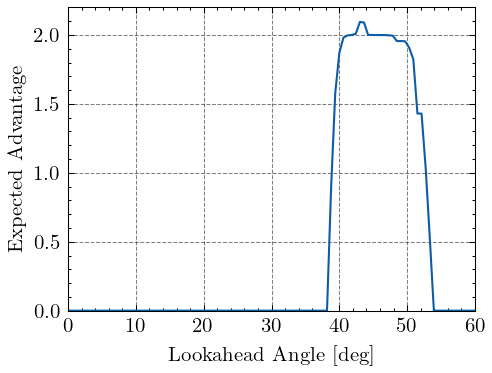

In [249]:
def get_minmax_request_times(requests, accesses, orbit, t, roll, pitch, t0):
    projected_requests = project_requests(requests, orbit, t, roll, pitch, t0)
    if projected_requests is None:
        return None, None

    # Get the indices of the requests that are in view
    inview_indices = np.where((projected_requests[:, 0] >= 0) & (projected_requests[:, 0] <= width) &
                               (projected_requests[:, 1] >= 0) & (projected_requests[:, 1] <= height))

    # Get the min and max times of the projected requests
    reqids = [requests[i].id for i in inview_indices[0]]
    accesstimes = [a.time for a in accesses if a.requestid in reqids]
    min_time = min(accesstimes) if accesstimes else None
    max_time = max(accesstimes) if accesstimes else None
    
    return min_time, max_time, inview_indices

def analytic_chain_probability(L, lam, M, c):
    """
    The renewal-process (Poisson process) approximation:
    We view the chain as starting at some point and then requiring M-1 gaps.
    Each gap is modeled as R = c + Exp(lam). The total additional waiting time is:
       S = (M-1)*c + Y, where Y ~ Gamma(M-1, rate=lam).
    For a chain to fit in [0,L] (ignoring where the chain starts), we require
       Y <= L - (M-1)*c.
    Thus the analytic probability is approximated by the Gamma CDF:
       P = GammaCDF( L - (M-1)*c; shape=M-1, scale=1/lam )
    Note: if L < (M-1)*c then P is zero.
    """
    if L < (M-1)*c:
        return 0.0
    x = L - (M-1)*c
    # Note: scipy's gamma.cdf(x, a, scale) uses 'a' as the shape and scale=1/rate.
    return st.gamma.cdf(x, a=M-1, scale=1/lam)

def expected_advantage(N, t_total, t_gap, A_min, A_max):
   all_adv = np.arange(A_min, A_max+1)

   probabilities = np.array([analytic_chain_probability(t_total, N/t_total * 1/3, adv + 2, t_gap) for adv in all_adv])
   probabilities = [probabilities[i] - probabilities[i+1] for i in range(len(probabilities)-1)]
   probabilities = np.append(probabilities, probabilities[-1])
   
   return np.sum(probabilities * all_adv)

def pitch_advantage(requests, accesses, orbit, t, roll, pitch, t0, t_gap):
    min_time, max_time, inview = get_minmax_request_times(requests, accesses, orbit, t0, roll, pitch, t0)
    total_inview = inview[0].shape[0]

    if total_inview == 0:
        return 0.0

    # Get the time difference between the min and max times of the projected requests
    if min_time is None or max_time is None:
        return 0.0

    t_total = (max_time - min_time).total_seconds()

    if (t_total == 0):
        return 0.0
    # Get expected advantage
    # print("t_total", t_total, "total_inview", total_inview, "t_gap", t_gap)
    return expected_advantage(total_inview, t_total, t_gap, 2, 20)

angles = np.linspace(0, 60, 100)
pitch_advantages = []
for angle in angles:
    advantage = pitch_advantage(requests, accesses, orbit, t0, 0, angle, t0, agility_bangbang(2))
    pitch_advantages.append(advantage)

plt.plot(angles, pitch_advantages)
plt.xlabel("Lookahead Angle [deg]")
plt.ylabel("Expected Advantage")
plt.xlim(0, 60)
plt.ylim(0)
plt.show()

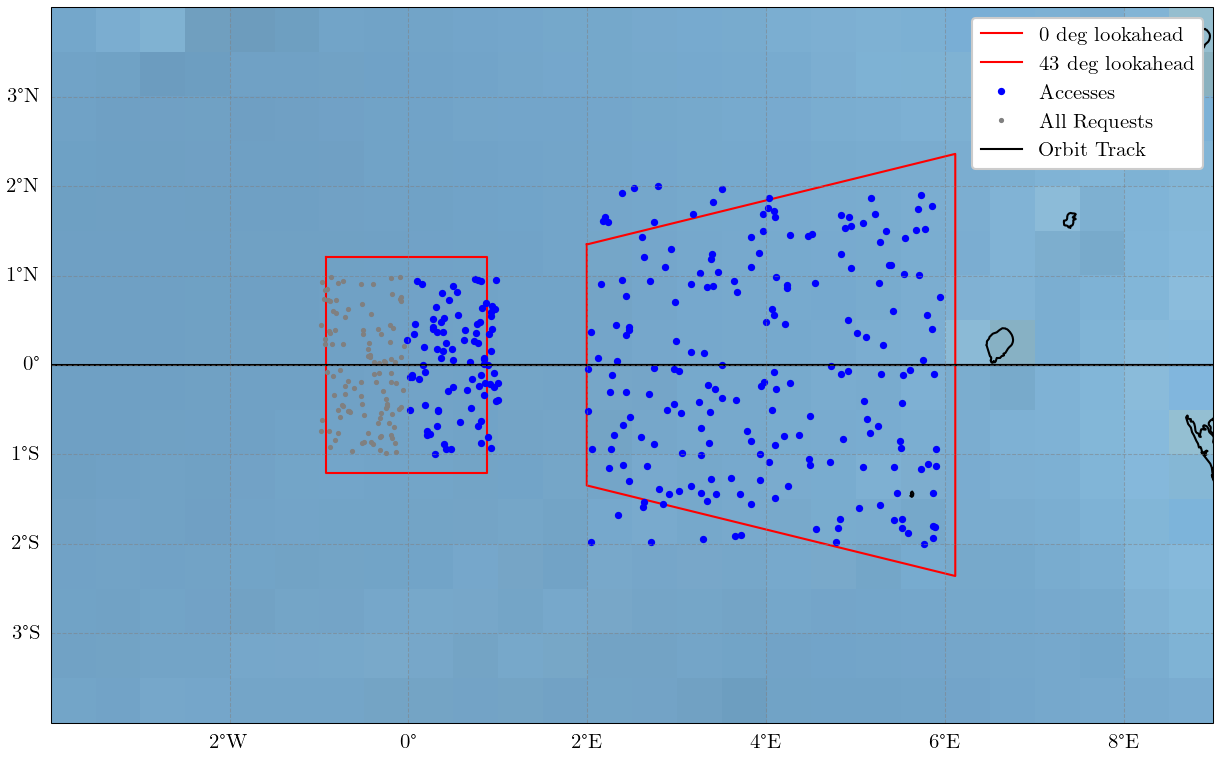

In [251]:
def roll2crosstrack(angle, h):
    R = Constants.R_E
    theta = np.radians(angle)
    return np.sign(theta) *  R * np.arccos(((R + h) * (np.sin(theta)) ** 2 + np.cos(theta) * np.sqrt(R**2 - ((R + h)**2) * (np.sin(theta) ** 2)))/(R))

def subtending_angle_from_fov(fov, h):
    sign = np.sign(fov)
    angle = np.abs(fov)
    
    beta = np.pi - np.arcsin((Constants.R_E + h)/(Constants.R_E) * np.sin(angle)) # obtuse angle
    
    theta = np.pi - (angle + beta)
    return theta * sign

# angle = -10
# print(roll2crosstrack(angle, orbit.a - Constants.R_E))
# print(Constants.R_E * subtending_angle_from_fov(np.deg2rad(angle), orbit.a - Constants.R_E))

def accesses2track(accesses, orbit, t0, t_end):
    v_orbit = v_orb(orbit.a - Constants.R_E)
    # Along, across...
    track = [(a.time - t0).total_seconds() * v_orbit for a in accesses]
    print([a.angle for a in accesses])
    roll2cr = [roll2crosstrack(a.angle, orbit.a - Constants.R_E) for a in accesses]
    
    return track, roll2cr

for a in accesses:
    a.state = {"observed": False}

# K = get_intrinsics(800, width//2, height//2)

fig = plt.figure(figsize=(10, 10))
# Create a cartopy GeoAxes with PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())
lookahead_plotted=False


box = np.array([
    [0, 0],
    [width, 0],
    [width, height],
    [0, height],
    [0, 0]
])
# For plotting
r , v = kepler2eci(orbit)
t = t0 + datetime.timedelta(seconds=0)

for p in [0, 43]:
    ecef_unprojected_dir = -(r - unproject_from_orbit(box, 1, K, orbit, t, pitch_angle=p, roll_angle=0))
    # Calculate Earth line intersections in ECI

    eci_intersections = [earth_line_intersection(r, d)[0] for d in ecef_unprojected_dir]
    # Convert to latlong
    latlong_intersections = [ecef2latlong(eci2ecef(i, t)) for i in eci_intersections]


    # Plot
    plt.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], 'r', transform=ccrs.PlateCarree(), label=f"{p} deg lookahead" if not lookahead_plotted else None)

# plt.plot([a.long for a in accesses if a.state["observed"]], [a.lat for a in accesses if a.state["observed"]], 'g.')

# plt.plot([a.long for a in accesses if not a.state["observed"]], [a.lat for a in accesses if not a.state["observed"]], 'r.')
# plt.show()

# Plot accesses
plt.plot([a.long for a in accesses], [a.lat for a in accesses], 'b.', transform=ccrs.PlateCarree(), label='Accesses', markersize=5)
plt.plot([r.long for r in requests if r not in [x.request for x in accesses]], [r.lat for r in requests if r not in [x.request for x in accesses]], '.', transform=ccrs.PlateCarree(), label="All Requests", color='grey', markersize=3)
# May as well plot the orbit track
orbit_latlong = [kepler2latlong(propagate_orbit(orbit, t), orbit.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end - t0).total_seconds(), 100)]
plt.plot([long for lat, long in orbit_latlong], [lat for lat, long in orbit_latlong], 'k-', label='Orbit Track')

# Add coastlines
ax.stock_img()
ax.coastlines()
ax.set_extent([-4, 9, -4, 4], crs=ccrs.PlateCarree())
ax.legend(frameon=True)

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right
plt.show()